# 06 — Findings & Recommendations

**Objective:** Synthesise all analyses into actionable recommendations for EU retailers.

## Structure
1. Executive summary — key numbers
2. Top opportunities — ranked with evidence
3. Category deep dives — top 3 picks with reformulation paths
4. Strategic recommendations — by retailer type
5. Limitations and future work

In [1]:
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

sns.set_theme(style='whitegrid', palette='colorblind')
os.makedirs('results', exist_ok=True)

# Load all processed data
scores = pd.read_parquet('data/processed/opportunity_scores.parquet')
cat_summary = pd.read_parquet('data/processed/category_summary.parquet')
df_off = pd.read_parquet('data/processed/off_eu_clean.parquet')

print(f'Opportunity scores: {len(scores)} categories')
print(f'OFF products: {len(df_off):,}')

Opportunity scores: 45 categories
OFF products: 2,568,269


---
## 1. Executive Summary

### The Opportunity
European food categories are dominated by unhealthy products, while private label presence among healthy alternatives is minimal. This creates a clear market opening.

In [2]:
# Key headline numbers
has_score = df_off['nutriscore_grade'].isin(['a', 'b', 'c', 'd', 'e'])
has_cat = df_off['category_l1'].notna() & (df_off['category_l1'] != 'Unknown')
df_scored = df_off[has_score & has_cat]

total_scored = len(df_scored)
pct_cde = df_scored['nutriscore_grade'].isin(['c', 'd', 'e']).mean()
median_gap = cat_summary['nutritional_gap'].median()
median_pl = cat_summary['pl_penetration'].median()
median_pl_ab = cat_summary['pl_penetration_ab'].median()
n_categories = len(cat_summary)
high_gap_cats = (cat_summary['nutritional_gap'] > 0.7).sum()

print('=' * 60)
print('EXECUTIVE SUMMARY — EU Private Label Health Opportunity')
print('=' * 60)
print(f'''
DATA SCOPE
  • {len(df_off):,} EU food products analysed (Open Food Facts)
  • {total_scored:,} with Nutri-Score grades across {n_categories} categories
  • Supermarket data from Mercadona (Spain) and Albert Heijn (Netherlands)

KEY FINDINGS
  • {pct_cde:.0%} of products score Nutri-Score C, D, or E (unhealthy)
  • Median PL penetration among healthy (A/B) products: only {median_pl_ab:.0%}
  • {high_gap_cats} of {n_categories} categories have nutritional gap > 0.7
  • Most categories are highly fragmented (low HHI) — easy to enter
  • Median PL discount vs national brands: ~22%

IMPLICATION
  → Retailers can capture the growing health-conscious segment by
    launching Nutri-Score A/B private label products in categories
    currently dominated by unhealthy options.
''')

EXECUTIVE SUMMARY — EU Private Label Health Opportunity

DATA SCOPE
  • 2,568,269 EU food products analysed (Open Food Facts)
  • 837,912 with Nutri-Score grades across 45 categories
  • Supermarket data from Mercadona (Spain) and Albert Heijn (Netherlands)

KEY FINDINGS
  • 73% of products score Nutri-Score C, D, or E (unhealthy)
  • Median PL penetration among healthy (A/B) products: only 13%
  • 18 of 45 categories have nutritional gap > 0.7
  • Most categories are highly fragmented (low HHI) — easy to enter
  • Median PL discount vs national brands: ~22%

IMPLICATION
  → Retailers can capture the growing health-conscious segment by
    launching Nutri-Score A/B private label products in categories
    currently dominated by unhealthy options.



---
## 2. Top 10 Opportunities — Ranked

Categories ranked by composite opportunity score (nutritional gap × brand fragmentation × category size × reformulation feasibility × PL opportunity).

In [3]:
# Top 10 opportunity table with key metrics
top10 = scores.head(10).copy()
top10['rank'] = range(1, 11)

display_df = top10[['rank', 'category_l1', 'opportunity_score', 'nutritional_gap',
                     'pct_grade_cde', 'pl_penetration', 'hhi', 'n_products']].copy()
display_df.columns = ['Rank', 'Category', 'Score', 'Nutri Gap', '% CDE',
                       'PL Penetration', 'HHI', 'Products']

# Format for readability
for col in ['Score', 'Nutri Gap']:
    display_df[col] = display_df[col].round(3)
for col in ['% CDE', 'PL Penetration']:
    display_df[col] = (display_df[col] * 100).round(1).astype(str) + '%'
display_df['HHI'] = display_df['HHI'].round(3)
display_df['Products'] = display_df['Products'].apply(lambda x: f'{x:,}')

print('Top 10 Private Label Opportunities in EU Food Categories\n')
display(display_df.set_index('Rank'))

Top 10 Private Label Opportunities in EU Food Categories



,Category,Score,Nutri Gap,% CDE,PL Penetration,HHI,Products
Rank,,,,,,,
1,Crepes And Galettes,0.689,0.843,93.7%,13.3%,0.009,"1,269"
2,Condiments & Sauces,0.672,0.767,89.5%,12.3%,0.003,"30,565"
3,Breakfast,0.663,0.935,98.4%,10.0%,0.003,"7,674"
4,Snacks,0.657,0.879,96.3%,12.3%,0.002,"119,433"
5,Spreads,0.655,0.810,95.1%,9.7%,0.003,"2,063"
6,Taralli,0.644,1.000,100.0%,0.0%,0.422,101
7,Fish And Meat And Eggs,0.632,0.926,96.8%,6.7%,0.033,"2,866"
8,Seafood,0.626,0.446,57.6%,19.0%,0.005,"28,310"
9,Meat Products,0.621,0.855,85.5%,0.0%,0.065,159


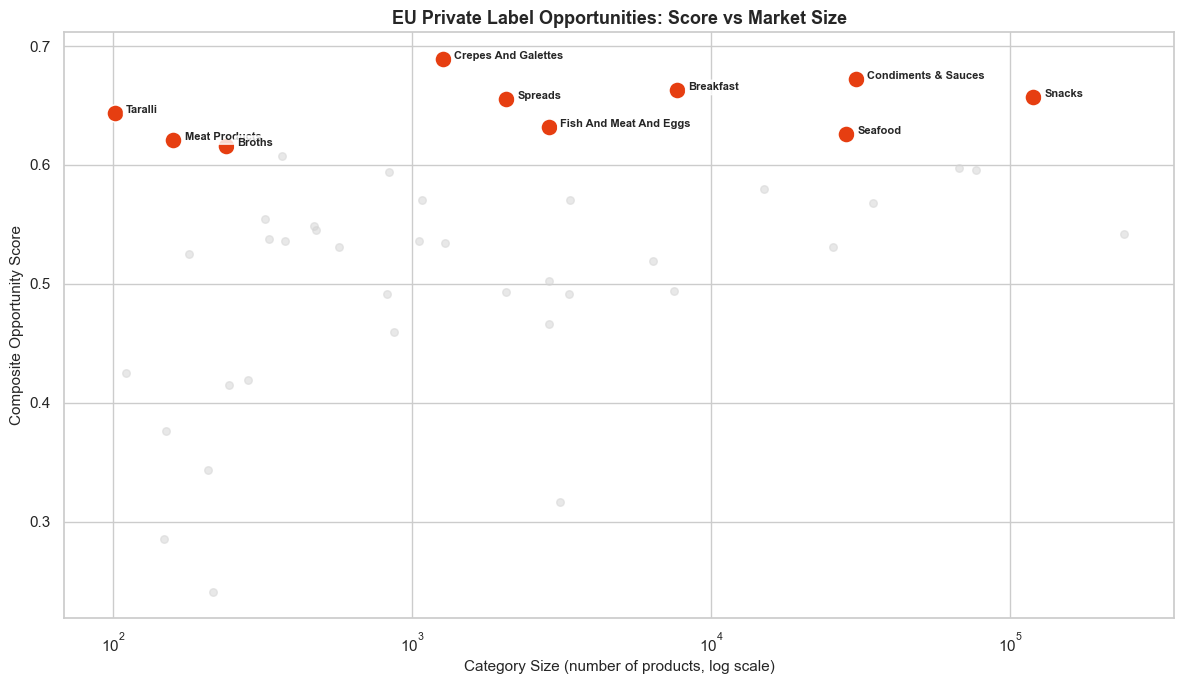

Saved: results/final_opportunity_map.png


In [4]:
# Visual: opportunity score vs market size, annotated
fig, ax = plt.subplots(figsize=(12, 7))

# All categories as grey dots
ax.scatter(scores['n_products'], scores['opportunity_score'],
           s=30, c='lightgrey', alpha=0.5, zorder=1)

# Top 10 highlighted
top = scores.head(10)
sc = ax.scatter(top['n_products'], top['opportunity_score'],
                s=150, c='#e63e11', edgecolors='white', linewidth=1, zorder=2)

for _, row in top.iterrows():
    ax.annotate(row['category_l1'],
                (row['n_products'], row['opportunity_score']),
                fontsize=8, fontweight='bold', ha='left',
                xytext=(8, 0), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.8))

ax.set_xscale('log')
ax.set_xlabel('Category Size (number of products, log scale)', fontsize=11)
ax.set_ylabel('Composite Opportunity Score', fontsize=11)
ax.set_title('EU Private Label Opportunities: Score vs Market Size', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('results/final_opportunity_map.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: results/final_opportunity_map.png')

---
## 3. Category Deep Dives — Top 3 Picks

For each of the top 3 actionable categories, we provide:
- Current nutritional landscape
- Specific reformulation targets
- Market entry assessment

In [5]:
from src.analysis.reformulation import analyse_reformulation

# Select actionable top 3 (excluding very small/niche categories)
actionable = scores[scores['n_products'] >= 1000].head(3)

for _, cat_row in actionable.iterrows():
    cat_name = cat_row['category_l1']
    cat_data = df_scored[df_scored['category_l1'] == cat_name]
    
    print('=' * 60)
    print(f'  {cat_name.upper()}')
    print('=' * 60)
    
    # Grade distribution
    grade_dist = cat_data['nutriscore_grade'].value_counts(normalize=True).sort_index()
    print(f'\n  Products: {len(cat_data):,}')
    print(f'  Opportunity Score: {cat_row["opportunity_score"]:.3f}')
    print(f'  Nutritional Gap: {cat_row["nutritional_gap"]:.3f}')
    print(f'  Brand Concentration (HHI): {cat_row["hhi"]:.3f}')
    print(f'  PL Penetration: {cat_row["pl_penetration"]:.1%}')
    print(f'\n  Nutri-Score Distribution:')
    for grade in 'abcde':
        pct = grade_dist.get(grade, 0)
        bar = '█' * int(pct * 40)
        print(f'    {grade.upper()}: {bar} {pct:.1%}')
    
    # Reformulation
    reform = analyse_reformulation(cat_data, category_col='category_l1', target_grade='b')
    if cat_name in reform:
        print(f'\n  Reformulation Path (→ Nutri-Score B):')
        for t in reform[cat_name]:
            print(f'    • Reduce {t.nutrient}: {t.current_median}g → {t.target_value}g ({t.reduction_pct:.0f}% reduction)')
    else:
        print(f'\n  Reformulation: No single-nutrient path to B — needs multi-factor reformulation')
    
    # Key nutrients (median for CDE products)
    cde = cat_data[cat_data['nutriscore_grade'].isin(['c', 'd', 'e'])]
    nutr_cols = ['sugars_100g', 'saturated_fat_100g', 'salt_100g', 'fiber_100g', 'proteins_100g']
    avail = [c for c in nutr_cols if c in cde.columns]
    if avail:
        medians = cde[avail].median()
        print(f'\n  Median Nutrients (CDE products):')
        for col in avail:
            label = col.replace('_100g', '').replace('_', ' ').title()
            print(f'    • {label}: {medians[col]:.1f}g per 100g')
    
    print()

  CREPES AND GALETTES

  Products: 1,587
  Opportunity Score: 0.689
  Nutritional Gap: 0.843
  Brand Concentration (HHI): 0.009
  PL Penetration: 13.3%

  Nutri-Score Distribution:
    A: █ 2.6%
    B: █ 3.3%
    C: ███████████████ 37.9%
    D: ██████████████ 36.7%
    E: ███████ 19.5%

  Reformulation Path (→ Nutri-Score B):
    • Reduce sugars_g: 14.2g → 9.0g (37% reduction)
    • Reduce saturated_fat_g: 2.3g → 1.0g (56% reduction)
    • Reduce salt_g: 0.9g → 0.7g (27% reduction)

  Median Nutrients (CDE products):
    • Sugars: 14.2g per 100g
    • Saturated Fat: 2.3g per 100g
    • Salt: 0.9g per 100g
    • Fiber: 1.7g per 100g
    • Proteins: 6.6g per 100g

  CONDIMENTS & SAUCES

  Products: 36,656
  Opportunity Score: 0.672
  Nutritional Gap: 0.767
  Brand Concentration (HHI): 0.003
  PL Penetration: 12.3%

  Nutri-Score Distribution:
    A: █ 4.1%
    B: ██ 6.0%
    C: █████████ 23.9%
    D: ███████████ 29.1%
    E: ██████████████ 36.8%

  Reformulation Path (→ Nutri-Score B):
 

---
## 4. Strategic Recommendations by Retailer Type

In [6]:
# Segment recommendations by retailer type
print('''
╔══════════════════════════════════════════════════════════════╗
║         STRATEGIC RECOMMENDATIONS BY RETAILER TYPE          ║
╚══════════════════════════════════════════════════════════════╝

━━━ DISCOUNT RETAILERS (Lidl, Aldi, Mercadona) ━━━━━━━━━━━━━━

  Priority categories: Snacks, Condiments & Sauces, Breakfast
  
  Strategy:
  • Focus on high-volume categories where PL already has price advantage
  • Launch Nutri-Score A/B versions of top-selling PL items
  • Leverage existing supply chain for reformulated products
  • Marketing: "Same great price, better nutrition"
  
  Quick wins:
  • Reduced-sugar breakfast cereals (target: <12g/100g)
  • Low-salt condiments and sauces
  • Baked (not fried) snack alternatives

━━━ PREMIUM SUPERMARKETS (Albert Heijn, Carrefour) ━━━━━━━━━━

  Priority categories: Spreads, Crepes & Galettes, Desserts
  
  Strategy:
  • Position health-focused PL as premium tier (AH Excellent, etc.)
  • Target health-conscious consumers willing to pay more
  • Emphasise clean-label and natural reformulation
  • Marketing: "Indulgence without compromise"
  
  Quick wins:
  • Sugar-reduced spreads and jams
  • Lighter crêpe/galette mixes (less sat fat)
  • Fibre-enriched dessert alternatives

━━━ ALL RETAILERS ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Cross-cutting opportunity:
  • EU Nutri-Score labelling is becoming mandatory in several countries
  • First-mover advantage: retailers with A/B PL portfolios will
    benefit when labelling drives consumer purchasing decisions
  • Brand fragmentation (low HHI) in most categories means
    shelf space is available without displacing strong incumbents
''')


╔══════════════════════════════════════════════════════════════╗
║         STRATEGIC RECOMMENDATIONS BY RETAILER TYPE          ║
╚══════════════════════════════════════════════════════════════╝

━━━ DISCOUNT RETAILERS (Lidl, Aldi, Mercadona) ━━━━━━━━━━━━━━

  Priority categories: Snacks, Condiments & Sauces, Breakfast

  Strategy:
  • Focus on high-volume categories where PL already has price advantage
  • Launch Nutri-Score A/B versions of top-selling PL items
  • Leverage existing supply chain for reformulated products
  • Marketing: "Same great price, better nutrition"

  Quick wins:
  • Reduced-sugar breakfast cereals (target: <12g/100g)
  • Low-salt condiments and sauces
  • Baked (not fried) snack alternatives

━━━ PREMIUM SUPERMARKETS (Albert Heijn, Carrefour) ━━━━━━━━━━

  Priority categories: Spreads, Crepes & Galettes, Desserts

  Strategy:
  • Position health-focused PL as premium tier (AH Excellent, etc.)
  • Target health-conscious consumers willing to pay more
  • Emphas

---
## 5. Summary Visualisation — The Opportunity Landscape

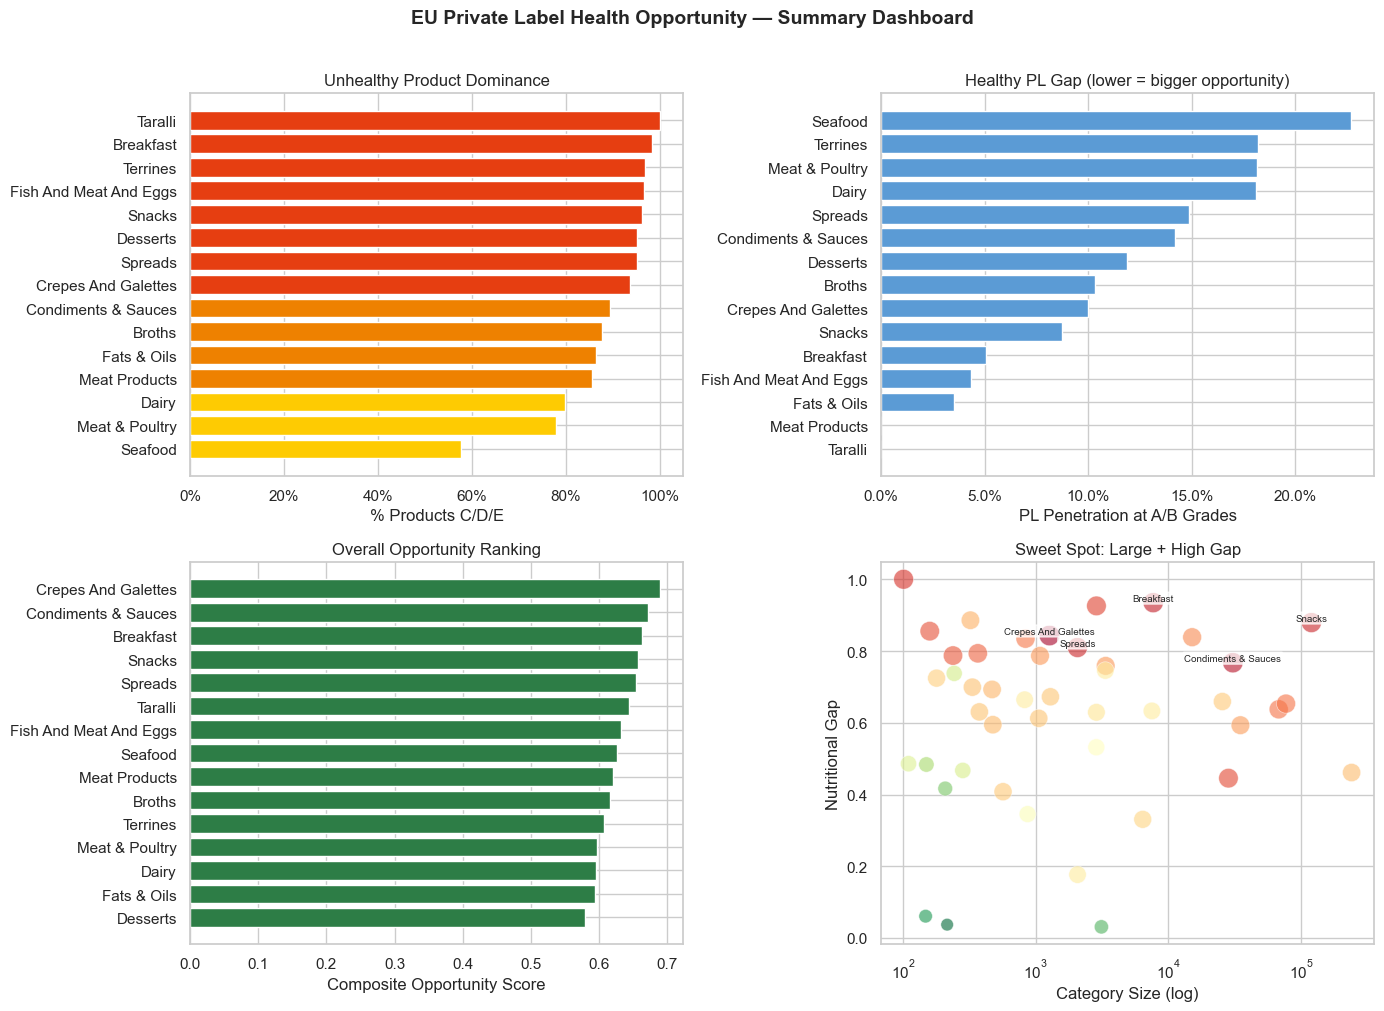

Saved: results/executive_dashboard.png


In [7]:
# Final summary: 2x2 panel of key charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: % CDE by category (top 15)
ax = axes[0, 0]
top15 = scores.head(15).sort_values('pct_grade_cde')
colors = ['#e63e11' if x > 0.9 else '#ee8100' if x > 0.8 else '#fecb02' for x in top15['pct_grade_cde']]
ax.barh(top15['category_l1'], top15['pct_grade_cde'], color=colors)
ax.set_xlabel('% Products C/D/E')
ax.set_title('Unhealthy Product Dominance')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Panel 2: PL penetration at A/B (low = opportunity)
ax = axes[0, 1]
top15_pl = scores.head(15).sort_values('pl_penetration_ab')
ax.barh(top15_pl['category_l1'], top15_pl['pl_penetration_ab'], color='#5b9bd5')
ax.set_xlabel('PL Penetration at A/B Grades')
ax.set_title('Healthy PL Gap (lower = bigger opportunity)')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Panel 3: Composite scores
ax = axes[1, 0]
top15_score = scores.head(15).sort_values('opportunity_score')
ax.barh(top15_score['category_l1'], top15_score['opportunity_score'], color='#2d7d46')
ax.set_xlabel('Composite Opportunity Score')
ax.set_title('Overall Opportunity Ranking')

# Panel 4: Market size vs gap scatter
ax = axes[1, 1]
ax.scatter(scores['n_products'], scores['nutritional_gap'],
           s=scores['opportunity_score'] * 300 + 10,
           c=scores['opportunity_score'], cmap='RdYlGn_r',
           alpha=0.6, edgecolors='white', linewidth=0.5)
for _, row in scores.head(5).iterrows():
    ax.annotate(row['category_l1'], (row['n_products'], row['nutritional_gap']),
                fontsize=7, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.15', fc='white', alpha=0.7))
ax.set_xscale('log')
ax.set_xlabel('Category Size (log)')
ax.set_ylabel('Nutritional Gap')
ax.set_title('Sweet Spot: Large + High Gap')

fig.suptitle('EU Private Label Health Opportunity — Summary Dashboard',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('results/executive_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: results/executive_dashboard.png')

---
## 6. Limitations & Future Work

In [8]:
print('''
╔══════════════════════════════════════════════════════════════╗
║                  LIMITATIONS & CAVEATS                      ║
╚══════════════════════════════════════════════════════════════╝

DATA LIMITATIONS
  1. Open Food Facts is crowd-sourced → selection bias toward
     products with prominent labels (unhealthy products with
     Nutri-Score displayed are over-represented)
  2. France dominates the dataset (~47% of EU products)
  3. Fruit/vegetable/nut % unavailable → Nutri-Score positive
     points may be underestimated for produce-rich products
  4. 59% Nutri-Score coverage after computation — 41% of
     products still lack sufficient nutrient data
  5. Fuzzy matching rates: 51% Mercadona, 41% AH — limits
     cross-referencing precision

ANALYTICAL LIMITATIONS
  6. No actual sales/revenue data — category "size" proxied
     by product count, not market value
  7. Price gap margin uses placeholder — real per-category
     pricing requires more granular supermarket data
  8. Reformulation feasibility is theoretical — real-world
     R&D, taste, shelf-life constraints not modelled
  9. HHI computed from OFF brand data which may not reflect
     actual market share distribution

FUTURE WORK
  • Add more retailer scrapers (Carrefour FR, Lidl, Aldi)
  • Integrate Nielsen/IRI sales data for revenue-weighted sizing
  • Build predictive model: what makes a PL health launch succeed?
  • Time-series: track Nutri-Score improvements over 12 months
  • Consumer survey: willingness-to-pay for healthier PL
  • Expand to non-EU markets (UK, Switzerland)
''')


╔══════════════════════════════════════════════════════════════╗
║                  LIMITATIONS & CAVEATS                      ║
╚══════════════════════════════════════════════════════════════╝

DATA LIMITATIONS
  1. Open Food Facts is crowd-sourced → selection bias toward
     products with prominent labels (unhealthy products with
     Nutri-Score displayed are over-represented)
  2. France dominates the dataset (~47% of EU products)
  3. Fruit/vegetable/nut % unavailable → Nutri-Score positive
     points may be underestimated for produce-rich products
  4. 59% Nutri-Score coverage after computation — 41% of
     products still lack sufficient nutrient data
  5. Fuzzy matching rates: 51% Mercadona, 41% AH — limits
     cross-referencing precision

ANALYTICAL LIMITATIONS
  6. No actual sales/revenue data — category "size" proxied
     by product count, not market value
  7. Price gap margin uses placeholder — real per-category
     pricing requires more granular supermarket data
  8

---

## Conclusion

This analysis demonstrates a clear, data-driven opportunity for EU retailers to differentiate their private label portfolios through health-positioned products. The combination of high nutritional gaps, fragmented competition, and regulatory momentum toward mandatory Nutri-Score labelling creates a compelling first-mover advantage.

**The bottom line:** In categories like Snacks (119K products, 88% unhealthy), Condiments & Sauces (31K products, 77% gap), and Breakfast (8K products, 93% gap), launching Nutri-Score A/B private label products is not just a health initiative — it's a market opportunity.